# Combine dat files from attended ApRES surveys on Thwaites glacier into netcdfs for archiving
### J. Kingslake, August 27th 2025
The code below collates the dat files collected in attended ApRES surveys on Thwaites Glacier between 2022 and 2024 by the GHOST team, part of the International Thwaites Glacier Collaboration. The data were collected by Elizabeth Case, Columbia University, then Utrecht University, Sierra Melton, Penn State University, Alex Brisbourne, British Antarctic Survey, Andrew Hoffman, Columbia University, then Rice University, and Ole Zeisling, Alfred Wegner Institute.

There are five different attended datasets:
- single shots collected in 2022-2023
- single shots collected in 2023-2024
- polarimetric data collected in 2022-2023 on the centerline
- polarimetric data collected in 2023-2024 on the centerline
- polarimetric data collected on the across line

We treat the single shot data and the polarimetric data separately below, then reload the netcdfs as a test. 


In [1]:
import matplotlib.pyplot as plt
import xapres as xa
import numpy as np
import xarray as xr
import os
import pandas as pd
import geopandas as gpd
import rioxarray
import os
import glob

## Define where the 5 different attended datasets are stored

In [2]:
source_root = "/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/"
directories = ["centerline/single/2022-2023", 
               "centerline/single/2023-2024",
               "centerline/polarimetric/2022-2023", 
               "centerline/polarimetric/2023-2024",
               "acrossline/polarimetric"              
               ]
netcdf_names = ['center_single_2022_2023',
                'center_single_2023_2024',
                'center_polarimetric_2022_2023',
                'center_polarimetric_2023_2024',
                'across_polarimetric'
               ]

## Two functions for tidying the datasets before writing to netcdf

In [3]:
def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds


def tidy_ds(ds):
# add attributes to lat lon and elevation
    ds.lat.attrs['long_name'] = 'latitude'
    ds.lat.attrs['units'] = 'degrees_north'
    ds.lat.attrs['notes'] = 'see spatial_ref coordinate for more information'
    ds.lon.attrs['long_name'] = 'longitude'
    ds.lon.attrs['units'] = 'degrees_east'
    ds.lon.attrs['notes'] = 'see spatial_ref coordinate for more information'
    ds.elevation.attrs['long_name'] = 'elevation'
    ds.elevation.attrs['units'] = 'm above sea level'
    ds.elevation.attrs['notes'] = 'see spatial_ref coordinate for more information'
    ds.Tx_Rx_bearing.attrs['long_name'] = 'Tx to RX bearing'
    ds.Tx_Rx_bearing.attrs['units'] = 'degrees clockwise from true north'

    ds = ds.squeeze()

    # add spatial ref information
    ds.rio.write_crs("EPSG:4326", inplace=True)

    # if they exists drop empty latitude and longitude variables
    if 'latitude' in ds.variables:
        ds = ds.drop_vars(['latitude', 'longitude'])

    # renane coords
    ds = ds.rename({'waypoint': 'waypoint_number', 'folder_name': 'waypoint_name'})

    # add the stacked chirps
    ds['chirp_stacked'] = ds.chirp.mean(dim='chirp_num', keep_attrs=True)

    # tidy up the units and attributes to work well with netcdfs 
    ds = remove_constants_attr(ds)
    ds.chirp_stacked.attrs['long_name'] = 'stacked de-ramped chirp'
    ds["chirp_time"].attrs["units"] = "unscaled seconds"

    return ds


## Single shots
Loop through the directories containing the single shots, adding position information, tidying up the result and saving as multiple netcdfs (to reduce the size of each file.)

In [ ]:
for directory, netcdf_name in zip(directories[:2], netcdf_names[:2]):
  # just the non-polarimetric ones. 
    source = source_root + directory
    files = xa.load.from_dats().list_files(source)
    print(source)
    waypoint = [os.path.dirname(f).split("/")[-1] for f in files]
    existing_directories = [os.path.dirname(f) for f in files]

    # load the waypoint positions
    w = pd.read_csv(source + "/positions.csv")
    w = gpd.GeoDataFrame(w, geometry=gpd.points_from_xy(w.loc[:,'lon (EPSG:4326 - WGS 84)'], w.loc[:,'lat (EPSG:4326 - WGS 84)'])) # convert to geodataframe using the lon and lat columns as the geometry
    w = w.set_crs('EPSG:4326') # define the crs to wgs84
    w.set_index('waypoint', inplace=True) # make the waypint names the index
    w.to_crs(3031, inplace=True) # convert to Antarctic Polar Stereographic projection

    # Define the paths to the files using the metadata (w)
    paths = [os.path.join(source, waypoint) for waypoint in w.index.to_list()]
    paths = [paths[i] for i in range(len(paths)) if paths[i] in existing_directories]  # filter paths to only those that exist
    print(f"Number of paths found: {len(paths)}")

    # put path_lists in order of waypoint number, based on the waypoint nnumber in w
    waypoint_from_paths = [os.path.basename(x).split('_')[-1] for x in paths]
    paths = [x for _, x in sorted(zip(w.loc[waypoint_from_paths,:].waypoint_number.to_list(), paths))]
    
    # define the number of files to process in each block
    dat_size = xa.load.from_dats().load_all(paths[0], attended=True, computeProfiles=False, disable_progress_bar = False).nbytes
    N = int(80*32e6/dat_size)  # number of files to process in each block
    file_lists = [paths[i:i + N] for i in range(0, len(paths), N)]
    #waypoint_number_lists = [list(range(i+1,i + N+1)) for i in range(0, len(paths), N)] 
    #waypoint_number_lists[-1] = waypoint_number_lists[-1][:len(file_lists[-1])]  # ensure the last list has the correct length

    lengths = [len(x) for x in file_lists]
    print(f"Number of blocks: {len(file_lists)}")
    print(f"Lengths of blocks: {lengths}")
    print(f"Total number of files: {sum(lengths)}")

    # create a directory for the netcdf(s)
    os.makedirs(f"{source}/netcdf", exist_ok=True) 
    
    # process each block of files
    for i, file_list in enumerate(file_lists):
        print(f"Processing {len(file_list)} files")
        ds_block = xa.load.from_dats().load_all(file_lists[i], attended=True, computeProfiles=False, disable_progress_bar = False)
        ds_block = ds_block.sel(chirp_num = slice(0,99))

        waypoint_names = ds_block.folder_name.values.tolist()[0]

        ds_block = ds_block.assign_coords({'lat': ('waypoint', w.loc[waypoint_names, 'lat (EPSG:4326 - WGS 84)']),\
                                           'lon': ('waypoint', w.loc[waypoint_names, 'lon (EPSG:4326 - WGS 84)']),\
                                           'elevation': ('waypoint', w.loc[waypoint_names, 'elevation (m; EPSG:4326 - WGS 84)']),\
                                           'Tx_Rx_bearing': ('waypoint', w.loc[waypoint_names, 'Tx_Rx_bearing (degrees clockwise from true north)']),\
                                           'waypoint': ('waypoint', w.loc[waypoint_names,'waypoint_number'])})

        # tidy the dataset
        ds_block = tidy_ds(ds_block)

        ds_block.attrs= {key: value for key, value in ds_block.attrs.items() if key == 'processing'}
        ds_block.attrs['antenna separation'] = '7 m'
        ds_block.attrs['readme'] = 'Attended autonomous radio-echo sounder (ApRES) measurements recorded on Thwaites Glacier in the 2022-23 and 2023-24 seasons. Collected by Elizabeth Case, Columbia University, then Utrecht University, Sierra Melton, Penn State University, Alex Brisbourne, British Antarctic Survey, and Ole Zeising, Alfred Wegner Institute. Funded by NSF-NERC grant number 1738934.'

        # save to netcdf
        nc_location = f'{source}/netcdf/{netcdf_name}_{ds_block.waypoint_number[0].values}_{ds_block.waypoint_number[-1].values}.nc' 
        print(f"Writing netcdf to {nc_location}")
        ds_block.to_netcdf(nc_location, mode='w',)

    print(f"Finished processing {directory} with {len(file_lists)} netcdfs created")
    print('------------------------------------------------------')
print("All single shots processed")

/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023
Number of paths found: 232
Number of blocks: 3
Lengths of blocks: [79, 79, 74]
Total number of files: 232
Processing 79 files
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/center_single_2022_2023_1_80.nc
Processing 79 files
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/center_single_2022_2023_81_163.nc
Processing 74 files
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/center_single_2022_2023_164_246.nc
Finished processing centerline/single/2022-2023 with 3 netcdfs created
------------------------------------------------------
/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2023-2024
Number of paths found: 93
Number of blocks: 2
Lengths of 

## Polarimetric
As these datasets are smaller there is no need to process them in blocks.

In [32]:
for directory, netcdf_name in zip(directories[2:], netcdf_names[2:]):   # just the polarimetrics ones.
    print(f"Processing {directory}")
    source = source_root + directory
    all_dirs = glob.glob(source + '/*')

    # load the waypoint positions
    w = pd.read_csv(source + "/positions.csv")
    w = gpd.GeoDataFrame(w, geometry=gpd.points_from_xy(w.loc[:,'lon (EPSG:4326 - WGS 84)'], w.loc[:,'lat (EPSG:4326 - WGS 84)'])) # convert to geodataframe using the lon and lat columns as the geometry
    w = w.set_crs('EPSG:4326') # definethe crs to wgs84
    w.set_index('waypoint', inplace=True) # make the waypint names the index
    w.to_crs(3031, inplace=True) # convert to Antarctic Polar Stereographic projection

    all_dirs = [d for d in all_dirs if os.path.isdir(d)]
    # exclude dirs called netcdf
    all_dirs = [d for d in all_dirs if not d.endswith('netcdf')]
    
    print(f"Found {len(all_dirs)} directories")
    all_dirs = sorted(all_dirs)

    ds = xa.load.from_dats().load_all(all_dirs, 
                                attended=True, polarmetric = True, 
                                computeProfiles=False, disable_progress_bar = False)
    waypoint_names = ds.folder_name.values.tolist()[0]    
    
    ds = ds.assign_coords({'lat': ('waypoint', w.loc[waypoint_names, 'lat (EPSG:4326 - WGS 84)']),\
                                    'lon': ('waypoint', w.loc[waypoint_names, 'lon (EPSG:4326 - WGS 84)']),\
                                    'elevation': ('waypoint', w.loc[waypoint_names, 'elevation (m; EPSG:4326 - WGS 84)']),\
                                    'Tx_Rx_bearing': ('waypoint', w.loc[waypoint_names, 'Tx_Rx_bearing (degrees clockwise from true north)']),\
                                    'waypoint': ('waypoint', w.loc[waypoint_names,'waypoint_number'])})
    
    # sort by waypoint number
    ds = ds.sortby('waypoint')

    # tidy the dataset
    ds = tidy_ds(ds)

    ds.attrs= {key: value for key, value in ds.attrs.items() if key == 'processing'}
    ds.attrs['antenna separation'] = '7 m'
    ds.attrs['readme'] = 'Attended autonomous radio-echo sounder (ApRES) measurements recorded on Thwaites Glacier in the 2022-23 and 2023-24 seasons. Collected by Elizabeth Case, Columbia University, then Utrecht University, Sierra Melton, Penn State University, Alex Brisbourne, British Antarctic Survey, and Ole Zeising, Alfred Wegner Institute. Funded by NSF-NERC grant number 1738934.'
    #ds['Tx_Rx_bearing'].attrs['description'] = 'Bearing from transmitter to receiver relative to true north.'
    #ds['Tx_Rx_bearing'].attrs['units'] = 'degrees'

    print (f"Dataset size: {ds.nbytes/1e9:.2f} GB")
    
    # create a directory for the netcdf(s)
    os.makedirs(f"{source}/netcdf", exist_ok=True) 

    # write netcdf
    netcdf_location = f"{source}/netcdf/{netcdf_name}.nc"
    print(f"Writing netcdf to {netcdf_location}")
    ds.to_netcdf(netcdf_location, mode='w')

Processing centerline/polarimetric/2022-2023
Found 43 directories
Dataset size: 5.56 GB
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/polarimetric/2022-2023/netcdf/center_polarimetric_2022_2023.nc
Processing centerline/polarimetric/2023-2024
Found 4 directories
Dataset size: 0.52 GB
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/polarimetric/2023-2024/netcdf/center_polarimetric_2023_2024.nc
Processing acrossline/polarimetric
Found 4 directories
Dataset size: 0.52 GB
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/acrossline/polarimetric/netcdf/across_polarimetric.nc


## Test: reload and plot data

In [33]:
ds

<xarray.Dataset> Size: 517MB
Dimensions:          (orientation: 4, waypoint_number: 4, chirp_num: 100,
                      chirp_time: 40001)
Coordinates: (12/14)
    time             (orientation, waypoint_number) datetime64[ns] 128B 2024-...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (orientation, waypoint_number) <U34 2kB 'Survey_2024-01-...
    waypoint_name    (orientation, waypoint_number) <U18 1kB 'PpRES_20240551_...
    AFGain           (waypoint_number) int64 32B -4 -4 -14 -4
    ...               ...
  * waypoint_number  (waypoint_number) int64 32B 1 2 3 4
    lat              (waypoint_number) float64 32B -76.46 -76.47 -76.47 -76.49
    lon              (waypoint_number) float64 32B -107.4 -106.6 -104.8 -107.0
    elevation        (waypoint_number) float64 32B nan nan nan nan
    Tx_Rx_bearing    (waypoint_number) float64 32B 0.0 0.0 0.0 0.0
    spatial_ref      int64 8B 0
Data variables:
    chirp            (orientation, waypoint_number, chirp_num, chirp_time) float64 512MB ...
    battery_voltage  (orientation, waypoint_number) float64 128B 4.036 ... 4.882
    temperature_1    (orientation, waypoint_number) float64 128B -6.187 ... -...
    temperature_2    (orientation, waypoint_number) float64 128B -11.58 ... -...
    chirp_stacked    (orientation, waypoint_number, chirp_time) float64 5MB 0...
Attributes:
    processing:          Created on 2025-09-01 16:19:11.919480
    antenna separation:  7 m
    readme:              Attended autonomous radio-echo sounder (ApRES) measu...

In [29]:
source_root + directories[0] + '/netcdf/*.nc'


'/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/*.nc'

In [34]:
def reload_and_plot(n):
    print(f"Reloading and plotting data from {directories[n]}")

    ds = xr.open_mfdataset(source_root + directories[n] + '/netcdf/*.nc')

    print (f"Dataset size: {ds.nbytes/1e9:.2f} GB")
    print(f"number of waypoints: {ds.sizes['waypoint_number']}")
    print(f"number of chirps: {ds.sizes['chirp_num']}")

    ds.temperature_1.plot()
    plt.title('Temperature sensor 1')
    plt.show()

    ds.chirp_stacked.plot()
    plt.title('Stacked chirps')
    plt.show()

    plt.plot(ds.lon, ds.lat, '.-')
    plt.xlabel('Latitude (degrees north)')
    plt.ylabel('Longitude (degrees east)')
    plt.title('Waypoint locations')
    plt.axis('equal')
    plt.show()

    ds.close()
    return ds


In [35]:
source_root + directories[0]

'/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023'

Reloading and plotting data from centerline/single/2022-2023
Dataset size: 7.50 GB
number of waypoints: 232
number of chirps: 100


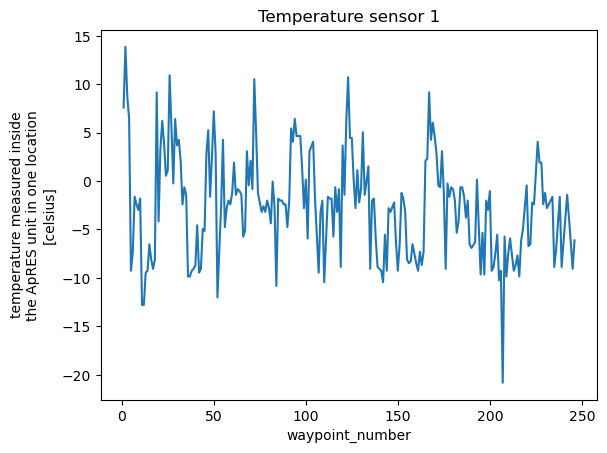

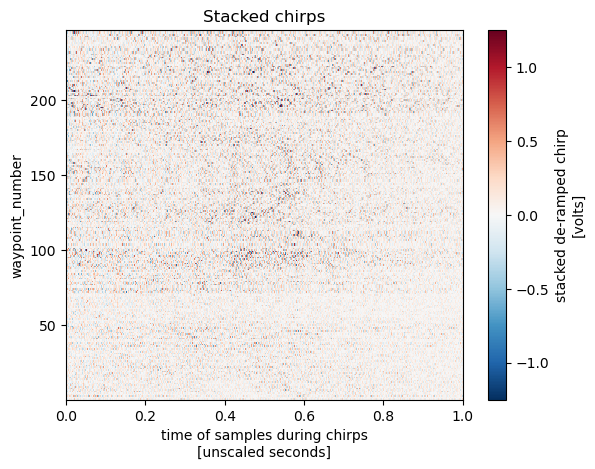

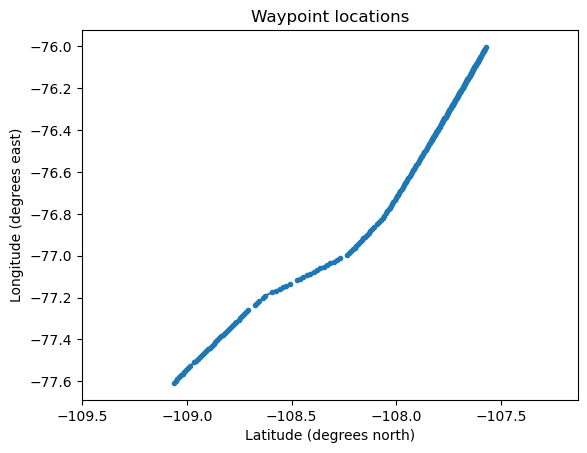

<xarray.Dataset> Size: 7GB
Dimensions:          (waypoint_number: 232, chirp_num: 100, chirp_time: 40001)
Coordinates: (12/14)
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    orientation      <U1 4B ''
    time             (waypoint_number) datetime64[ns] 2kB dask.array<chunksize=(79,), meta=np.ndarray>
    filename         (waypoint_number) <U33 31kB dask.array<chunksize=(79,), meta=np.ndarray>
    waypoint_name    (waypoint_number) <U10 9kB dask.array<chunksize=(79,), meta=np.ndarray>
    ...               ...
  * waypoint_number  (waypoint_number) int64 2kB 1 2 3 4 5 ... 242 243 245 246
    lat              (waypoint_number) float64 2kB dask.array<chunksize=(79,), meta=np.ndarray>
    lon              (waypoint_number) float64 2kB dask.array<chunksize=(79,), meta=np.ndarray>
    elevation        (waypoint_number) float64 2kB dask.array<chunksize=(79,), meta=np.ndarray>
    Tx_Rx_bearing    (waypoint_number) float64 2kB dask.array<chunksize=(79,), meta=np.ndarray>
    spatial_ref      int64 8B 0
Data variables:
    chirp            (waypoint_number, chirp_num, chirp_time) float64 7GB dask.array<chunksize=(79, 100, 40001), meta=np.ndarray>
    battery_voltage  (waypoint_number) float64 2kB dask.array<chunksize=(79,), meta=np.ndarray>
    temperature_1    (waypoint_number) float64 2kB dask.array<chunksize=(79,), meta=np.ndarray>
    temperature_2    (waypoint_number) float64 2kB dask.array<chunksize=(79,), meta=np.ndarray>
    chirp_stacked    (waypoint_number, chirp_time) float64 74MB dask.array<chunksize=(79, 40001), meta=np.ndarray>
Attributes:
    processing:          Created on 2025-09-01 16:17:39.335079
    antenna separation:  7 m
    readme:              Attended autonomous radio-echo sounder (ApRES) measu...

In [36]:
ds0 = reload_and_plot(0)
ds0

Reloading and plotting data from centerline/single/2023-2024
Dataset size: 3.01 GB
number of waypoints: 93
number of chirps: 100


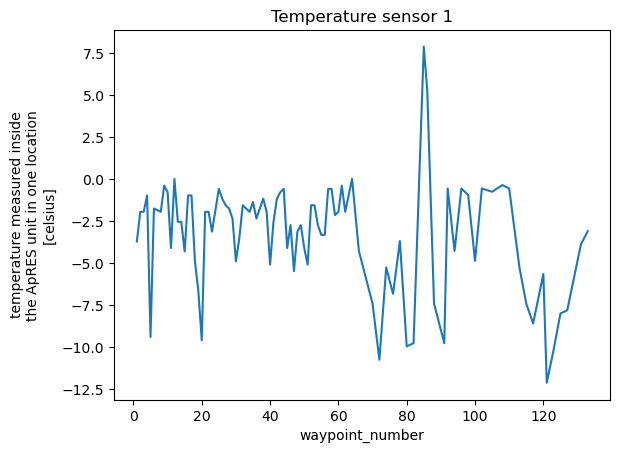

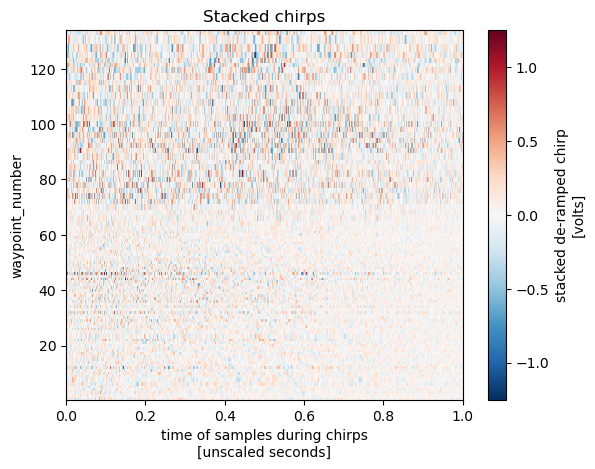

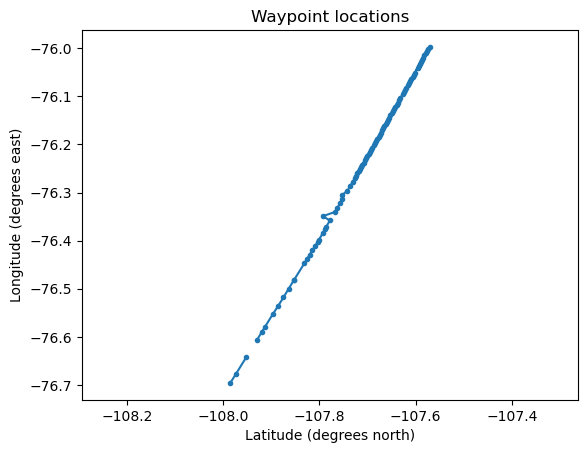

In [37]:
ds1 = reload_and_plot(1)

Reloading and plotting data from centerline/polarimetric/2022-2023
Dataset size: 5.56 GB
number of waypoints: 43
number of chirps: 100


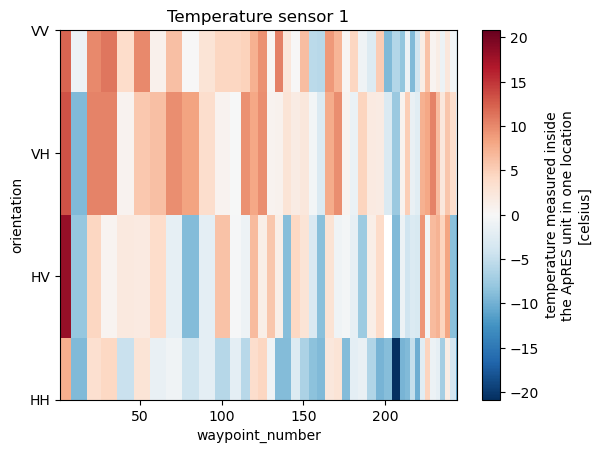

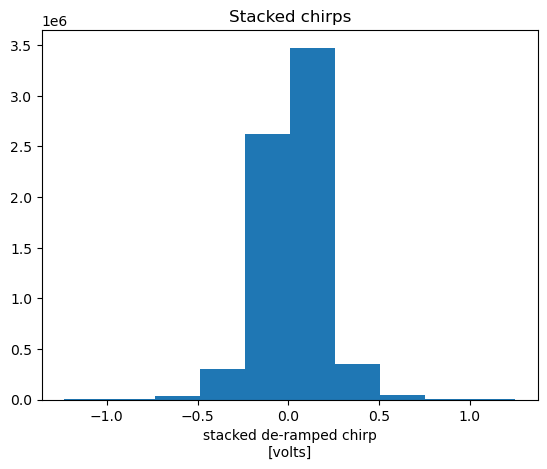

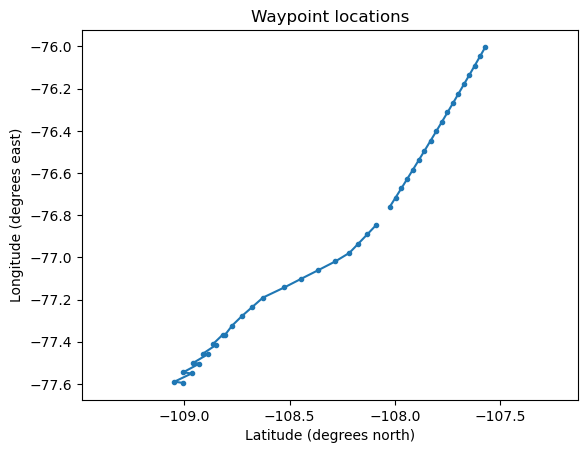

<xarray.Dataset> Size: 6GB
Dimensions:          (orientation: 4, waypoint_number: 43, chirp_num: 100,
                      chirp_time: 40001)
Coordinates: (12/14)
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * orientation      (orientation) <U2 32B 'HH' 'HV' 'VH' 'VV'
    time             (orientation, waypoint_number) datetime64[ns] 1kB dask.array<chunksize=(4, 43), meta=np.ndarray>
    filename         (orientation, waypoint_number) <U35 24kB dask.array<chunksize=(4, 43), meta=np.ndarray>
    waypoint_name    (orientation, waypoint_number) <U10 7kB dask.array<chunksize=(4, 43), meta=np.ndarray>
    ...               ...
  * waypoint_number  (waypoint_number) int64 344B 1 14 21 31 ... 236 237 243 244
    lat              (waypoint_number) float64 344B dask.array<chunksize=(43,), meta=np.ndarray>
    lon              (waypoint_number) float64 344B dask.array<chunksize=(43,), meta=np.ndarray>
    elevation        (waypoint_number) float64 344B dask.array<chunksize=(43,), meta=np.ndarray>
    Tx_Rx_bearing    (waypoint_number) float64 344B dask.array<chunksize=(43,), meta=np.ndarray>
    spatial_ref      int64 8B ...
Data variables:
    chirp            (orientation, waypoint_number, chirp_num, chirp_time) float64 6GB dask.array<chunksize=(4, 43, 100, 40001), meta=np.ndarray>
    battery_voltage  (orientation, waypoint_number) float64 1kB dask.array<chunksize=(4, 43), meta=np.ndarray>
    temperature_1    (orientation, waypoint_number) float64 1kB dask.array<chunksize=(4, 43), meta=np.ndarray>
    temperature_2    (orientation, waypoint_number) float64 1kB dask.array<chunksize=(4, 43), meta=np.ndarray>
    chirp_stacked    (orientation, waypoint_number, chirp_time) float64 55MB dask.array<chunksize=(4, 43, 40001), meta=np.ndarray>
Attributes:
    processing:          Created on 2025-09-01 16:18:56.395900
    antenna separation:  7 m
    readme:              Attended autonomous radio-echo sounder (ApRES) measu...

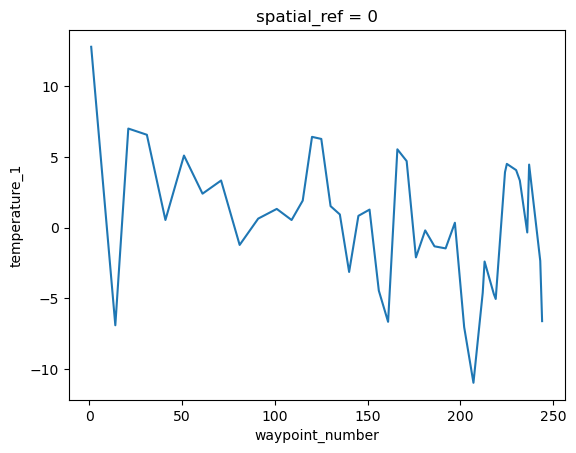

In [38]:
ds2 = reload_and_plot(2)
ds2.temperature_1.mean(dim = 'orientation').plot();
ds2

Reloading and plotting data from centerline/polarimetric/2023-2024
Dataset size: 0.52 GB
number of waypoints: 4
number of chirps: 100


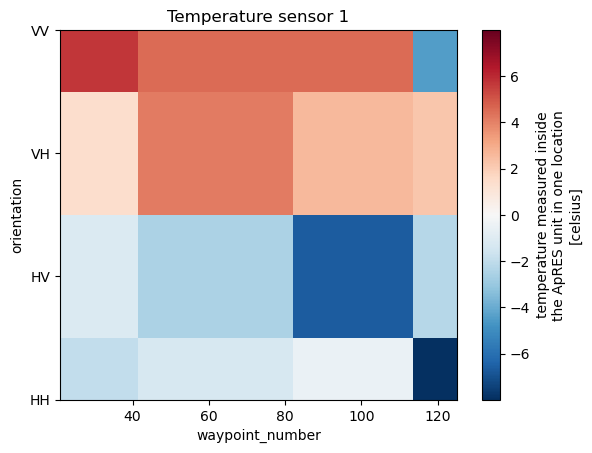

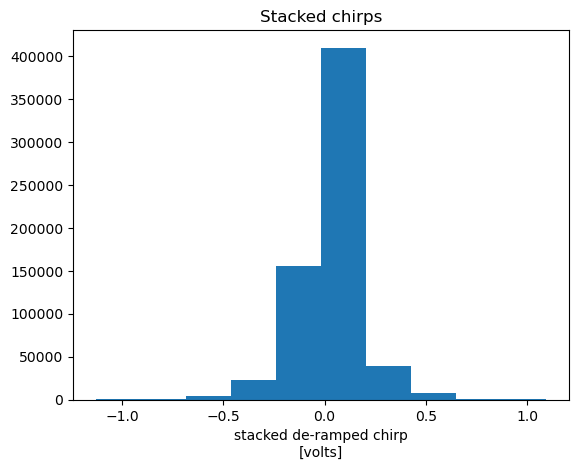

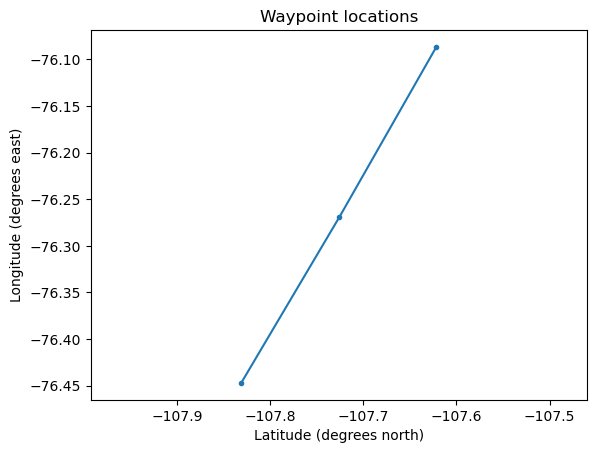

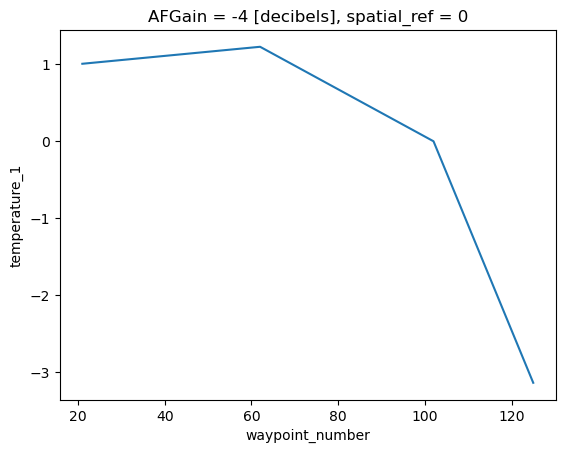

In [39]:
ds3 = reload_and_plot(3)
ds3.temperature_1.mean(dim = 'orientation').plot();

Reloading and plotting data from acrossline/polarimetric
Dataset size: 0.52 GB
number of waypoints: 4
number of chirps: 100


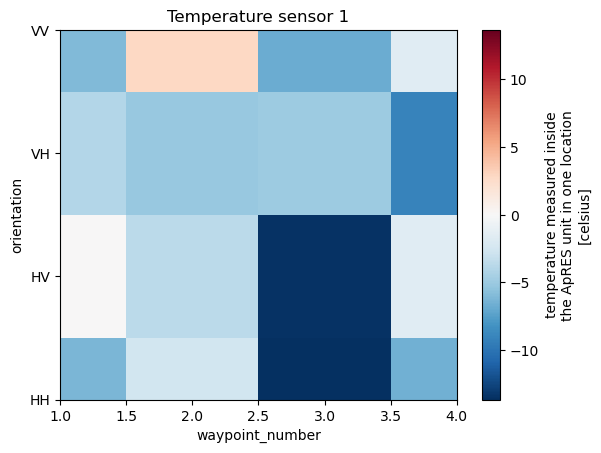

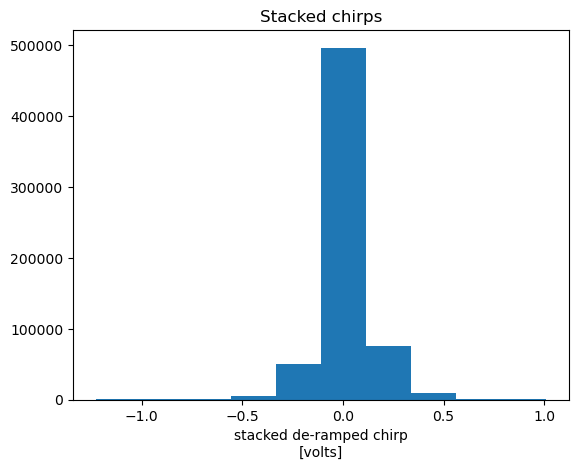

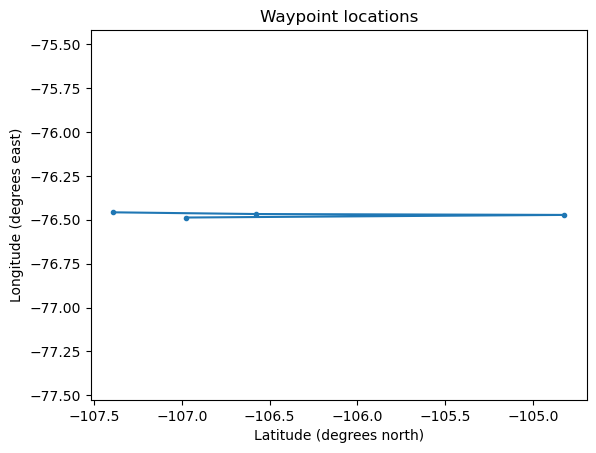

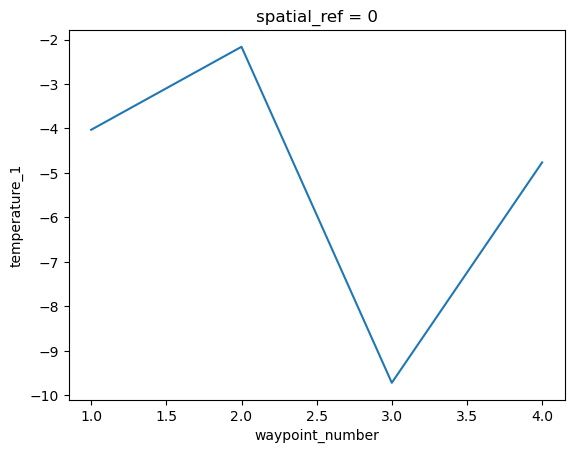

In [40]:
ds4 = reload_and_plot(4)
ds4.temperature_1.mean(dim = 'orientation').plot();

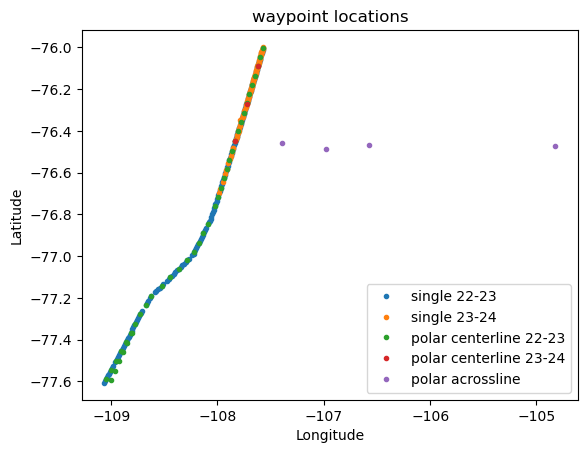

In [42]:
plt.plot(ds0.lon, ds0.lat, '.', label = 'single 22-23')
plt.plot(ds1.lon, ds1.lat, '.', label = 'single 23-24')
plt.plot(ds2.lon, ds2.lat, '.', label = 'polar centerline 22-23')
plt.plot(ds3.lon, ds3.lat, '.', label = 'polar centerline 23-24')
plt.plot(ds4.lon, ds4.lat, '.', label = 'polar acrossline')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('waypoint locations')
plt.legend()